<font size="+3"><strong>8.2. Test Driven Development</strong></font>

In the previous lesson, we learned how to get data from an API. In this lesson, we have two goals. First, we'll take the code we used to access the API and build an `AlphaVantageAPI` class. This will allow us to reuse our code. Second, we'll create a `SQLRepository` class that will help us load our stock data into a SQLite database and then extract it for later use. Additionally, we'll build this code using a technique called **test driven development**, where we'll use `assert` statements to make sure everything is working properly. That way, we'll avoid issues later when we build our application.

In [2]:

import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

from config import settings


C:\Users\MEER\anaconda3\lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_directory" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(


# Building Our Data Module

For our application, we're going to keep all the classes we use to extract, transform, and load data in a single module that we'll call `data`.

## AlphaVantage API Class

Let's get started by taking the code we created in the last lesson and incorporating it into a class that will be in charge of getting data from the AlphaVantage API.

**Task 8.2.1:** In the `data` module, create a class definition for `AlphaVantageAPI`. For now, making sure that it has an `__init__` method that attaches your API key as the attribute `__api_key`. Once you're done, import the class below and create an instance of it called `av`.

In [3]:
# Import `AlphaVantageAPI`
from data import AlphaVantageAPI

# Create instance of `AlphaVantageAPI` class
av = AlphaVantageAPI()

print("av type:", type(av))

av type: <class 'data.AlphaVantageAPI'>


Remember the `get_daily` function we made in the last lesson? Now we're going to turn it into a class method.

**Task 8.2.2:** Create a `get_daily` method for your `AlphaVantageAPI` class. Once you're done, use the cell below to fetch the stock data for the renewable energy company [Suzlon](https://www.suzlon.com/) and assign it to the DataFrame `df_suzlon`.

In [4]:
# Define Suzlon ticker symbol
ticker = "SUZLON.BSE"

# Use your `av` object to get daily data
df_suzlon = av.get_daily(ticker=ticker)

print("df_suzlon type:", type(df_suzlon))
print("df_suzlon shape:", df_suzlon.shape)
df_suzlon.head()

df_suzlon type: <class 'pandas.core.frame.DataFrame'>
df_suzlon shape: (100, 5)


,open,high,low,close,volume
date,,,,,
2023-09-28,25.75,26.40,25.5,25.63,19550292.0
2023-09-27,25.19,25.93,25.1,25.65,14521270.0
2023-09-26,25.59,26.10,25.0,25.98,22453990.0
2023-09-25,25.75,26.02,25.1,25.50,14709970.0
2023-09-22,25.53,25.86,24.5,25.05,10115690.0


Okay! The next thing we need to do is test our new method to make sure it works the way we want it to. Usually, these sorts of tests are written *before* writing the method, but, in this first case, we'll do it the other way around in order to get a better sense of how assert statements work.

**Task 8.2.3:** Create four assert statements to test the output of your `get_daily` method. Use the comments below as a guide.

In [5]:
# Does `get_daily` return a DataFrame?
assert isinstance(df_suzlon, pd.DataFrame)

# Does DataFrame have 5 columns?
assert df_suzlon.shape[1] == 5

# Does DataFrame have a DatetimeIndex?
assert isinstance(df_suzlon.index,pd.DatetimeIndex)

# Is the index name "date"?
assert df_suzlon.index.name == "date"

**Task 8.2.4:** Create two more tests for the output of your `get_daily` method. Use the comments below as a guide.

In [6]:
# Does DataFrame have correct column names?
assert df_suzlon.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']

# Are columns correct data type?
assert all(df_suzlon.dtypes==float)

Okay! Now that our `AlphaVantageAPI` is ready to get data, let's turn our focus to the class we'll need for storing our data in our SQLite database.<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

## SQL Repository Class

It wouldn't be efficient if our application needed to get data from the AlphaVantage API every time we wanted to explore our data or build a model, so we'll need to store our data in a database. Because our data is highly structured (each DataFrame we extract from AlphaVantage is always going to have the same five columns), it makes sense to use a SQL database.

We'll use SQLite for our database. For consistency, this database will always have the same name, which we've stored in our `.env` file.

**Task 8.2.5:** Connect to the database whose name is stored in the `.env` file for this project. Be sure to set the `check_same_thread` argument to `False`. Assign the connection to the variable `connection`.

In [7]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)

print("connection type:", type(connection))

connection type: <class 'sqlite3.Connection'>


We've got a connection, and now we need to start building the class that will handle all our transactions with the database. With this class, though, we're going to create our tests *before* writing the class definition.

**Task 8.2.6:** Write two tests for the `SQLRepository` class, using the comments below as a guide.

In [8]:
# Import class definition
from data import SQLRepository

# Create instance of class
repo = SQLRepository(connection=connection)

# Does `repo` have a "connection" attribute?
assert hasattr(repo, "connection")

# Is the "connection" attribute a SQLite `Connection`?
assert isinstance(repo.connection, sqlite3.Connection)

<div class="alert alert-info" role="alert">
    <p><b>Tip:</b> You won't be able to run this ☝️ code block until you complete the task below. 👇</p>
</div>

**Task 8.2.7:** Create a definition for your `SQLRepository` class. For now, just complete the `__init__` method. Once you're done, use the code you wrote in the previous task to test it.

The next method we need for the `SQLRepository` class is one that allows us to store information. In SQL talk, this is generally referred to as **inserting** tables into the database.

**Task 8.2.8:** Add an `insert_table` method to your `SQLRepository` class. As a guide use the assert statements below and the docstring in the `data` module. When you're done, run the cell below to check your work.

In [9]:
response = repo.insert_table(table_name=ticker, records=df_suzlon, if_exists="replace")

# Does your method return a dictionary?
assert isinstance(response, dict)

# Are the keys of that dictionary correct?
assert sorted(list(response.keys())) == ["records_inserted", "transaction_successful"]

If our method is passing the assert statements, we know it's returning a record of the database transaction, but we still need to check whether the data has actually been added to the database.

**Task 8.2.9:** Write a SQL query to get the **first five rows** of the table of Suzlon data you just inserted into the database.


In [13]:
%%sql

select * from "SUZLON.BSE"
LIMIt 5

UsageError: Cell magic `%%sql` not found.


We can get **insert** data into our database, but let's not forget that we need to **read** data from it, too. Reading will be a little more complex than inserting, so let's start by writing code in this notebook before we incorporate it into our `SQLRepository` class.

**Task 8.2.10:** First, write a SQL query to get **all** the Suzlon data. Then use pandas to extract the data from the database and read it into a DataFrame, names `df_suzlon_test`.

In [14]:
sql = "select * from 'SUZLON.BSE'"
df_suzlon_test = pd.read_sql(
    sql=sql,con=connection, parse_dates=["date"], index_col = "date"
)

print("df_suzlon_test type:", type(df_suzlon_test))
print()
print(df_suzlon_test.info())
df_suzlon_test.head()

df_suzlon_test type: <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2023-09-28 to 2023-05-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    100 non-null    float64
 1   high    100 non-null    float64
 2   low     100 non-null    float64
 3   close   100 non-null    float64
 4   volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB
None


,open,high,low,close,volume
date,,,,,
2023-09-28,25.75,26.40,25.5,25.63,19550292.0
2023-09-27,25.19,25.93,25.1,25.65,14521270.0
2023-09-26,25.59,26.10,25.0,25.98,22453990.0
2023-09-25,25.75,26.02,25.1,25.50,14709970.0
2023-09-22,25.53,25.86,24.5,25.05,10115690.0


Now that we know how to read a table from our database, let's turn our code into a proper function. But since we're doing backwards designs, we need to start with our tests.

**Task 8.2.11:** <a id="task-8211"></a>Complete the assert statements below to test your `read_table` function. Use the comments as a guide.

In [15]:
# Assign `read_table` output to `df_suzlon`
df_suzlon = repo.read_table(table_name="SUZLON.BSE", limit=2500)  # noQA F821

# Is `df_suzlon` a DataFrame?
assert isinstance(df_suzlon,pd.DataFrame)

# Does it have a `DatetimeIndex`?
assert isinstance(df_suzlon.index,pd.DatetimeIndex)

# Is the index named "date"?
assert df_suzlon.index.name == "date"

# Does it have 2,500 rows and 5 columns?

assert df_suzlon.shape == (100,5)

# Are the column names correct?
assert df_suzlon.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']

# Are the column data types correct?
assert all(df_suzlon.dtypes == float)

# Print `df_suzlon` info
print("df_suzlon shape:", df_suzlon.shape)
print()
print(df_suzlon.info())
df_suzlon.head()

df_suzlon shape: (100, 5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2023-09-28 to 2023-05-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    100 non-null    float64
 1   high    100 non-null    float64
 2   low     100 non-null    float64
 3   close   100 non-null    float64
 4   volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB
None


,open,high,low,close,volume
date,,,,,
2023-09-28,25.75,26.40,25.5,25.63,19550292.0
2023-09-27,25.19,25.93,25.1,25.65,14521270.0
2023-09-26,25.59,26.10,25.0,25.98,22453990.0
2023-09-25,25.75,26.02,25.1,25.50,14709970.0
2023-09-22,25.53,25.86,24.5,25.05,10115690.0


<div class="alert alert-info" role="alert">
    <p><b>Tip:</b> You won't be able to run this ☝️ code block until you complete the task below. 👇</p>
</div>

**Task 8.2.12:** Expand on the code you're written above to complete the `read_table` function below. Use the docstring as a guide.

<div class="alert alert-info" role="alert">
    <p><b>Tip:</b> Remember that we stored our data sorted <b>descending</b> by date. It'll definitely make our <code>read_table</code> easier to implement!</p>
</div>

In [16]:
def read_table(table_name,limit=None):
    

    """Read table from database.

    Parameters
    ----------
    table_name : str
        Name of table in SQLite database.
    limit : int, None, optional
        Number of most recent records to retrieve. If `None`, all
        records are retrieved. By default, `None`.

    Returns
    -------
    pd.DataFrame
        Index is DatetimeIndex "date". Columns are 'open', 'high',
        'low', 'close', and 'volume'. All columns are numeric.
    """
    # Create SQL query (with optional limit)
    if limit:
        sql = f"SELECT * FROM '{table_name}' LIMIT {limit}"
    else:
        sql = f"SELECT * FROM '{table_name}'"
    

    # Retrieve data, read into DataFrame
    df = pd.read_sql(
        sql=sql,con=connection, parse_dates=["date"], index_col = "date"
        )

    # Return DataFrame
    return df

**Task 8.2.13:** Turn the `read_table` function into a method for your `SQLRepository` class.

**Task 8.2.14:** Return to task <a href="#task-8211">Task 8.2.11</a> and change the code so that you're testing your class method instead of your notebook function.

Excellent! We have everything we need to get data from AlphaVantage, save that data in our database, and access it later on. Now it's time to do a little exploratory analysis to compare the stocks of the two companies we have data for. 

# Comparing Stock Returns
We already have the data for Suzlon Energy in our database, but we need to add the data for Ambuja Cement before we can compare the two stocks.

**Task 8.2.15:** Use the instances of the `AlphaVantageAPI` and `SQLRepository` classes you created in this lesson (`av` and `repo`, respectively) to get the stock data for Ambuja Cement and read it into the database.

In [17]:
ticker = "AMBUJACEM.BSE"

# Get Ambuja data using `av`
ambuja_records = av.get_daily(ticker=ticker)

# Insert `ambuja_records` database using `repo`
response = repo.insert_table(table_name = ticker,records=ambuja_records,if_exists="replace" )

response

{'records_inserted': None, 'transaction_successful': True}

**Task 8.2.16:** Using the `read_table` method you've added to your `SQLRepository`, extract the most recent 2,500 rows of data for Ambuja Cement from the database and assign the result to `df_ambuja`.

In [18]:
ticker = "AMBUJACEM.BSE"
df_ambuja = repo.read_table(table_name=ticker,limit=2500)

print("df_ambuja type:", type(df_ambuja))
print("df_ambuja shape:", df_ambuja.shape)
df_ambuja.head()

df_ambuja type: <class 'pandas.core.frame.DataFrame'>
df_ambuja shape: (100, 5)


,open,high,low,close,volume
date,,,,,
2023-09-28,430.50,431.45,418.50,420.10,96569.0
2023-09-27,427.40,431.35,426.00,430.50,41243.0
2023-09-26,423.15,433.80,422.55,429.65,117821.0
2023-09-25,420.95,425.65,414.90,422.60,94261.0
2023-09-22,425.40,428.50,418.25,420.35,84318.0


We've spent a lot of time so far looking at this data, but what does it actually represent? It turns out the stock market is a lot like any other market: people buy and sell goods. The prices of those goods can go up or down depending on factors like supply and demand. In the case of a stock market, the goods being sold are stocks (also called equities or securities), which represent an ownership stake in a corporation.

During each trading day, the price of a stock will change, so when we're looking at whether a stock might be a good investment, we look at four types of numbers: open, high, low, close, volume. **Open** is exactly what it sounds like: the selling price of a share when the market opens for the day. Similarly, **close** is the selling price of a share when the market closes at the end of the day, and **high** and **low** are the respective maximum and minimum prices of a share over the course of the day. **Volume** is the number of shares of a given stock that have been bought and sold that day. Generally speaking, a firm whose shares have seen a high volume of trading will see more price variation of the course of the day than a firm whose shares have been more lightly traded.

Let's visualize how the price of Ambuja Cement changes over the last decade.m

**Task 8.2.17:** Plot the closing price of `df_ambuja`. Be sure to label your axes and include a legend.

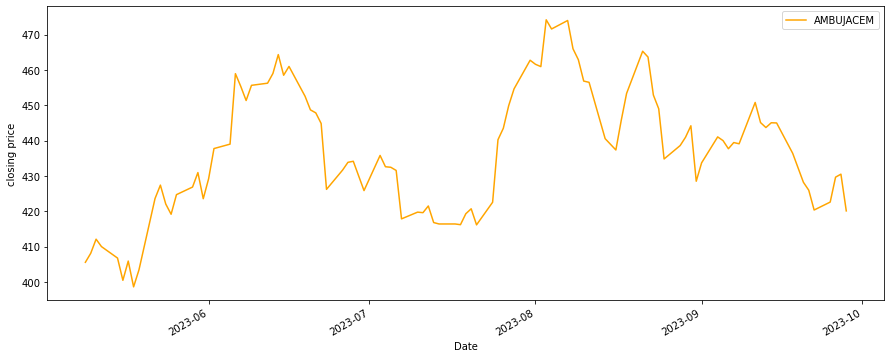

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_ambuja` closing price
df_ambuja["close"].plot(ax=ax, label="AMBUJACEM", color="orange")

# Label axes
plt.xlabel("Date")
plt.ylabel("closing price")


# Add legend
plt.legend()

Let's add the closing price of Suzlon to our graph so we can compare the two.

**Task 8.2.18:** Create a plot that shows the closing prices of `df_suzlon` and `df_ambuja`. Again, label your axes and include a legend.

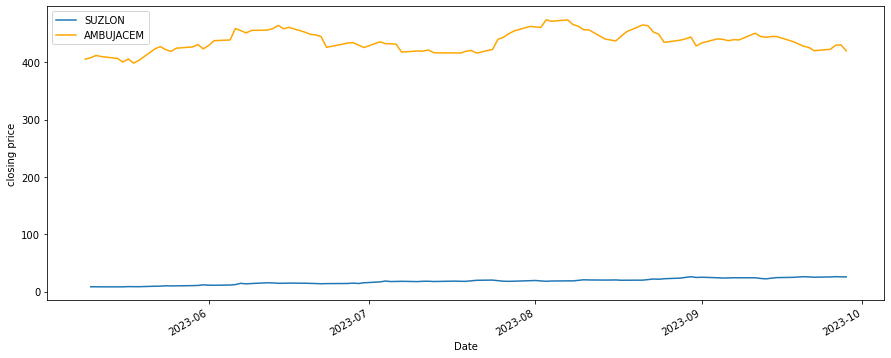

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_suzlon` and `df_ambuja`
df_suzlon["close"].plot(ax=ax, label="SUZLON")
df_ambuja["close"].plot(ax=ax, label="AMBUJACEM", color="orange")

# Label axes
plt.xlabel("Date")
plt.ylabel("closing price")


# Add legend
plt.legend()


Looking at this plot, we might conclude that Ambuja Cement is a "better" stock than Suzlon energy because its price is higher. But price is just one factor that an investor must consider when creating an investment strategy. What is definitely true is that it's hard to do a head-to-head comparison of these two stocks because there's such a large price difference.

One way in which investors compare stocks is by looking at their **returns** instead. A return is the change in value in an investment, represented as a percentage. So let's look at the daily returns for our two stocks.

**Task 8.2.19:** Add a `"return"` column to `df_ambuja` that shows the percentage change in the `"close"` column from one day to the next.

<div class="alert alert-info" role="alert">
    <p><b>Tip:</b> Our two DataFrames are sorted <b>descending</b> by date, but you'll need to make sure they're sorted <b>ascending</b> in order to calculate their returns.</p>
</div>

In [23]:
# Sort DataFrame ascending by date
df_ambuja.sort_index(ascending=True, inplace=True)

# Create "return" column
df_ambuja["return"] = df_ambuja["close"].pct_change()*100

print("df_ambuja shape:", df_ambuja.shape)
print(df_ambuja.info())
df_ambuja.head()

df_ambuja shape: (100, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2023-05-09 to 2023-09-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    100 non-null    float64
 1   high    100 non-null    float64
 2   low     100 non-null    float64
 3   close   100 non-null    float64
 4   volume  100 non-null    float64
 5   return  99 non-null     float64
dtypes: float64(6)
memory usage: 5.5 KB
None


,open,high,low,close,volume,return
date,,,,,,
2023-05-09,406.60,412.30,403.25,405.55,423787.0,NaN
2023-05-10,407.00,409.20,402.55,408.10,102748.0,0.628776
2023-05-11,409.05,415.00,406.25,412.10,179565.0,0.980152
2023-05-12,410.10,414.85,407.50,410.00,150594.0,-0.509585
2023-05-15,409.10,410.80,403.00,406.75,243622.0,-0.792683


**Task 8.2.20:** Add a `"return"` column to `df_suzlon

In [24]:
# Sort DataFrame ascending by date
df_suzlon.sort_index(ascending=True, inplace=True)

# Create "return" column
df_suzlon["return"] = df_suzlon["close"].pct_change()*100

print("df_suzlon shape:", df_suzlon.shape)
print(df_suzlon.info())
df_suzlon.head()

df_suzlon shape: (100, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2023-05-10 to 2023-09-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    100 non-null    float64
 1   high    100 non-null    float64
 2   low     100 non-null    float64
 3   close   100 non-null    float64
 4   volume  100 non-null    float64
 5   return  99 non-null     float64
dtypes: float64(6)
memory usage: 5.5 KB
None


,open,high,low,close,volume,return
date,,,,,,
2023-05-10,8.40,8.45,8.22,8.38,14444902.0,NaN
2023-05-11,8.38,8.47,8.28,8.33,14821269.0,-0.596659
2023-05-12,8.36,8.40,8.21,8.24,12964748.0,-1.080432
2023-05-15,8.27,8.35,8.20,8.24,16903221.0,0.000000
2023-05-16,8.27,8.32,8.19,8.22,15089860.0,-0.242718


**Task 8.2.21:** Plot the returns for `df_suzlon` and `df_ambuja`. Be sure to label your axes and use legend.

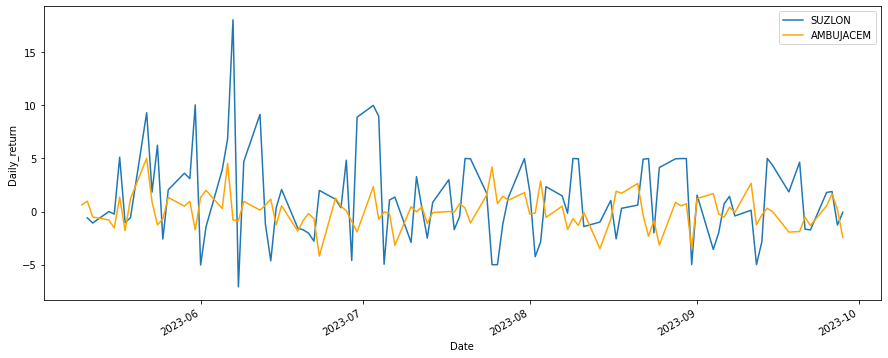

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_suzlon` and `df_ambuja`
df_suzlon["return"].plot(ax=ax, label="SUZLON")
df_ambuja["return"].plot(ax=ax, label="AMBUJACEM", color="orange")

# Label axes
plt.xlabel("Date")
plt.ylabel("Daily_return")


# Add legend
plt.legend()


Success! By representing returns as a percentage, we're able to compare two stocks that have very different prices. But what is this visualization telling us? We can see that the returns for Suzlon have a wider spread. We see big gains and big losses. In contrast, the spread for Ambuja is narrower, meaning that the price doesn't fluctuate as much. 

Another name for this day-to-day fluctuation in returns is called [**volatility**](https://en.wikipedia.org/wiki/Volatility_(finance)), which is another important factor for investors. So in the next lesson, we'll learn more about volatility and then build a time series model to predict it.